In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA 
import plotly.express as px # for interactive 3D plots

In [2]:
df = pd.read_csv(r"C:\PHY199\flux_matrix_9.txt", sep=" ", header=None )
wavelengths = np.arange(3683, 5300.01, 0.3) 
print("Length:", len(wavelengths)) 
df.columns = wavelengths 
df.head()

Length: 5391


,3683.0,3683.3,3683.6,3683.9,3684.2,3684.5,3684.8,3685.1,3685.4,3685.7,...,5297.3,5297.6,5297.9,5298.2,5298.5,5298.8,5299.1,5299.4,5299.7,5300.0
0,-4.989580,12.663800,11.38310,-0.201817,21.36420,-0.453198,-9.06977,-0.929764,-6.97285,0.46532,...,1.73604,1.01951,0.275119,0.004004,-0.360292,-0.798352,-0.535391,-0.880986,-1.16191,-0.597853
1,-2.331660,-0.793800,9.64592,-9.762460,-7.94443,4.396200,-16.61250,-1.650000,-3.37611,-11.64470,...,1.73604,1.01951,0.275119,0.004004,-0.360292,-0.798352,-0.535391,-0.880986,-1.16191,-0.597853
2,-5.034760,-0.271275,-4.15207,-12.675400,-7.05741,-5.788340,9.71644,4.490780,8.20901,12.59930,...,-15.00320,-13.27620,-7.052950,-4.204860,-15.563300,1.796800,1.224930,-6.484790,-3.55349,-19.217600
3,15.144400,1.358030,-2.60297,-9.361900,-1.30515,-0.629790,13.42450,-2.771910,-15.48720,-15.59390,...,1.73604,1.01951,0.275119,0.004004,-0.360292,-0.798352,-0.535391,-0.880986,-1.16191,-0.597853
4,-0.772324,3.952020,-12.67780,20.732600,4.14593,2.156990,-5.59428,-12.355600,-7.41995,-3.05225,...,1.73604,1.01951,0.275119,0.004004,-0.360292,-0.798352,-0.535391,-0.880986,-1.16191,-0.597853


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# 0) Point to your flux DataFrame from the previous cell (adjust the name if needed)
#    I’ll try a few common names to match your notebook.
for _cand in ("flux_df", "df", "flux_matrix_df"):
    if _cand in globals():
        F = globals()[_cand].copy()
        break
else:
    raise NameError("Couldn't find your flux DataFrame. Set F = <your DataFrame> before running this cell.")

# 1) Identify wavelength columns by “convertible-to-float”, preserve original labels, sort by numeric wavelength
num_cols = []
for col in F.columns:
    try:
        val = float(str(col).strip())
        num_cols.append((val, col))   # (numeric_wavelength, original_label)
    except Exception:
        pass

if not num_cols:
    raise ValueError("No wavelength-like columns detected. Make sure your flux DataFrame has wavelength columns.")

num_cols.sort(key=lambda t: t[0])
wl = np.array([v for v, _lab in num_cols], dtype=float)              # numeric wavelengths for x-axis
ordered_labels = [lab for _v, lab in num_cols]                       # original labels for column selection
F_wl = F[ordered_labels]                                             # keep original labels to avoid KeyErrors

# 2) Compute PC0 (mean spectrum) and first 3 principal components
X = F_wl.to_numpy(dtype=float)
pc0_mean = np.nanmean(X, axis=0)

pca = PCA(n_components=min(4, X.shape[1]), svd_solver="full", random_state=42)
pca.fit(X)
if pca.components_.shape[0] < 3:
    raise ValueError("Not enough features for 3 principal components. Check the flux matrix shape.")

pc1_vec, pc2_vec, pc3_vec = pca.components_[0], pca.components_[1], pca.components_[2]

# 3) Scale PCs for visibility against the mean
def scale_component_to_mean(comp_vec, mean_vec, frac=0.25):
    dyn = float(np.nanmax(mean_vec) - np.nanmin(mean_vec))
    target = max(dyn * frac, 1e-12)
    comp_mag = np.nanpercentile(np.abs(comp_vec), 99)
    if comp_mag <= 0 or np.isnan(comp_mag):
        return comp_vec
    return comp_vec * (target / comp_mag)

pc1_plot = scale_component_to_mean(pc1_vec, pc0_mean, frac=0.25)
pc2_plot = scale_component_to_mean(pc2_vec, pc0_mean, frac=0.25)
pc3_plot = scale_component_to_mean(pc3_vec, pc0_mean, frac=0.25)

# 4) Line list (absorption/emission)
line_dict = {
    '2326.00' : 'CII]',
    '2344.21' : 'FeII',
    '2374.46' : 'FeII',
    '2382.76' : 'FeII',
    '2586.65' : 'FeII',
    '2600.17' : 'FeII',
    '2796.35' : 'MgII',
    '2803.53' : 'MgII',
    '3727.0921' : 'OII',
    '3771' : 'Hι',
    '3798' : 'Hθ',
    '3835.40' : 'Hη',
    '3869' : 'NeIII',
    '3889.06' : 'Hζ',
    '3970.08' : 'Hε',
    '4102.89' : 'Hδ',
    '4341.68' : 'Hγ',
    '4862.68' : 'Hβ',
    '4932.603' : 'OIII',
    '4960.295' : 'OIII',
    '5008.240' : 'OIII',
    '6549.86' : 'NII',
    '6564.61' : 'Hα',
    '6585.27' : 'NII',
    '6718.29' : 'SII',
    '6732.67' : 'SII',
    '3934.777' : 'K',
    '3969.588' : 'H',
    '4305.61' : 'G',
    '5176.7' : 'Mg',
    '5269.5' : 'FeI',
    '5328.0' : 'FeI',
    '5371.5' : 'FeI',
    '5895.6' : 'Na',
    '8500.36' : 'CaII',
    '8544.44' : 'CaII',
    '8664.52' : 'CaII',
    '5578.5' : 'Sky',
    '5894.6' : 'Sky',
    '6301.7' : 'Sky',
    '6880' : 'Sabs',
    '7246.0' : 'Sky'
}

wl_min, wl_max = float(wl.min()), float(wl.max())
in_range_lines = sorted(
    [(float(k), v) for k, v in line_dict.items() if wl_min <= float(k) <= wl_max],
    key=lambda t: t[0]
)

# 5) Build Plotly figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=wl, y=pc0_mean, mode="lines", name="PC0: Mean Spectrum",
    hovertemplate="λ=%{x:.2f} Å<br>Flux=%{y:.3e}<extra></extra>"
))
fig.add_trace(go.Scatter(
    x=wl, y=pc1_plot, mode="lines", name="PC1 (scaled)",
    hovertemplate="λ=%{x:.2f} Å<br>PC1=%{y:.3e}<extra></extra>"
))
fig.add_trace(go.Scatter(
    x=wl, y=pc2_plot, mode="lines", name="PC2 (scaled)",
    hovertemplate="λ=%{x:.2f} Å<br>PC2=%{y:.3e}<extra></extra>"
))
fig.add_trace(go.Scatter(
    x=wl, y=pc3_plot, mode="lines", name="PC3 (scaled)",
    hovertemplate="λ=%{x:.2f} Å<br>PC3=%{y:.3e}<extra></extra>"
))

# 6) Vertical markers for lines (only those within wavelength range)
y_min, y_max = float(np.nanmin(pc0_mean)), float(np.nanmax(pc0_mean))
y_pad = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
annot_y = y_max + y_pad

for lam, label in in_range_lines:
    fig.add_vline(x=lam, line_width=1, line_dash="dot", line_color="gray")
    fig.add_annotation(
        x=lam, y=annot_y, text=label, showarrow=False,
        textangle=-90, yanchor="bottom", font=dict(size=10),
        bgcolor="rgba(255,255,255,0.6)"
    )

# 7) Layout
explained = pca.explained_variance_ratio_
fig.update_layout(
    title=(
        "PC0 (Mean) and First 3 Principal Components<br>"
        f"Explained variance ratios: PC1={explained[0]:.3%}, "
        f"PC2={explained[1]:.3%}, PC3={explained[2]:.3%}"
    ),
    xaxis_title="Wavelength (Å)",
    yaxis_title="Flux / (arbitrary units for PCs)",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    margin=dict(l=40, r=20, t=90, b=40),
)

fig.show()


In [3]:
pca = PCA(n_components=20) 
X_pca = pca.fit_transform(df) 
df_pca = pd.DataFrame(X_pca, columns=[
    "principal_component_1", 
    "principal_component_2", 
    "principal_component_3", 
    "principal_component_4", 
    "principal_component_5", 
    "principal_component_6", 
    "principal_component_7", 
    "principal_component_8", 
    "principal_component_9", 
    "principal_component_10", 
    "principal_component_11", 
    "principal_component_12", 
    "principal_component_13", 
    "principal_component_14", 
    "principal_component_15", 
    "principal_component_16", 
    "principal_component_17", 
    "principal_component_18", 
    "principal_component_19", 
    "principal_component_20", 
    ]) 
df_pca.head()

,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6,principal_component_7,principal_component_8,principal_component_9,principal_component_10,principal_component_11,principal_component_12,principal_component_13,principal_component_14,principal_component_15,principal_component_16,principal_component_17,principal_component_18,principal_component_19,principal_component_20
0,-148.459764,-133.430698,-71.888069,27.324792,-4.702217,-8.986888,-9.127853,0.782550,5.807255,-7.931479,13.605611,-8.681458,-15.347559,7.539132,-16.495837,-19.337917,-29.134303,0.741548,2.219644,5.814047
1,-109.279624,-151.661544,-117.382604,-0.226236,-19.073843,-16.524969,-8.593259,-2.629083,-31.799041,-6.327754,20.247781,0.327753,-20.567390,-0.518474,-19.795645,13.028666,-10.508068,-6.822204,-2.421545,22.833464
2,225.399428,-138.213557,-55.297965,-14.622744,-1.032978,3.015099,-4.388457,-6.743157,-0.580058,1.813123,10.278242,28.523589,24.869587,12.607815,-17.253323,36.796779,-18.900214,9.170269,7.534947,-33.636007
3,-4.364758,-73.331921,34.121614,-3.270150,-11.182782,-19.869604,6.031501,-18.599453,6.463535,-1.387043,-8.051907,21.564794,-64.353587,-1.157175,-6.788357,-7.776038,-20.367965,6.996850,-0.766036,-3.172523
4,-97.721731,-171.213220,-62.032588,-0.309534,33.756255,-19.802454,-65.798684,71.814266,-10.574830,-36.481402,51.464614,-39.410203,-30.134992,-14.077934,-11.327043,-19.187407,-33.485723,-15.311554,21.103972,-69.908221


In [4]:
var_ratio = pca.explained_variance_ratio_ 
sum_var_ratio = var_ratio.sum() 
print("Explained variance ratio by each principal component:") 
for i, v in enumerate(var_ratio, start=1): 
    print(f" PC{i}: {v:.4f}") 
    print(f"\nTotal variance explained by the first 40 PCs: {sum_var_ratio:.4f}")

Explained variance ratio by each principal component:
 PC1: 0.0678

Total variance explained by the first 40 PCs: 0.2375
 PC2: 0.0219

Total variance explained by the first 40 PCs: 0.2375
 PC3: 0.0135

Total variance explained by the first 40 PCs: 0.2375
 PC4: 0.0117

Total variance explained by the first 40 PCs: 0.2375
 PC5: 0.0114

Total variance explained by the first 40 PCs: 0.2375
 PC6: 0.0102

Total variance explained by the first 40 PCs: 0.2375
 PC7: 0.0095

Total variance explained by the first 40 PCs: 0.2375
 PC8: 0.0093

Total variance explained by the first 40 PCs: 0.2375
 PC9: 0.0089

Total variance explained by the first 40 PCs: 0.2375
 PC10: 0.0086

Total variance explained by the first 40 PCs: 0.2375
 PC11: 0.0085

Total variance explained by the first 40 PCs: 0.2375
 PC12: 0.0074

Total variance explained by the first 40 PCs: 0.2375
 PC13: 0.0070

Total variance explained by the first 40 PCs: 0.2375
 PC14: 0.0065

Total variance explained by the first 40 PCs: 0.2375
 PC

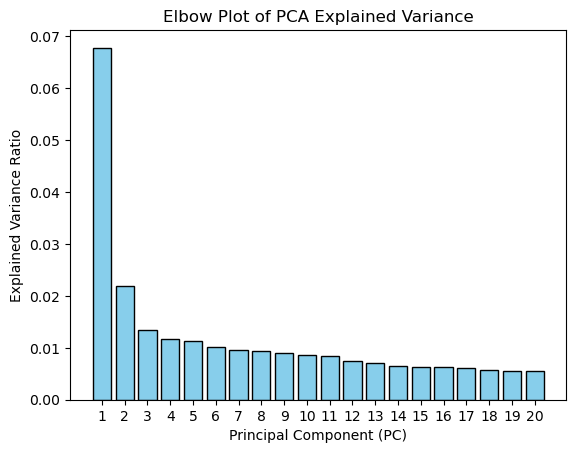

In [5]:
# Replace these with your actual explained variance ratios in order: 
pcs = range(1, len(var_ratio) + 1) 
plt.bar(pcs, var_ratio, color='skyblue', edgecolor='black') 
plt.xlabel("Principal Component (PC)") 
plt.ylabel("Explained Variance Ratio") 
plt.title("Elbow Plot of PCA Explained Variance") 
plt.xticks(pcs) 
plt.show()

In [6]:
largest_amplitude_dict = {} 
for i in range(X_pca.shape[0]): 
    row = X_pca[i] 
    j = np.argmax(np.abs(row)) 
    # index of the PC with the largest absolute coefficient 
    amplitude = row[j] 
    # multiply amplitude by the fraction of variance explained by that PC 
    amplitude_weighted = amplitude * var_ratio[j] 
    # store amplitude, PC number, and amplitude * variance in a dictionary 
    largest_amplitude_dict[i] = (amplitude, j+1, amplitude_weighted) 
    
# sort by absolute amplitude, descending 
sorted_list = sorted(largest_amplitude_dict.items(), 
                     key=lambda x: abs(x[1][2]), 
                     reverse=True ) 
# print top 20 
print("Top 10 largest PC coefficients:") 
for rank, (spec_idx, (amp, pc_idx, amp_weight)) in enumerate(sorted_list[:10], start=1): 
    print(f"{rank}. Spectrum #{spec_idx}: "f"largest PC amplitude = {amp:.4f} (PC {pc_idx}), " f"amplitude * variance = {amp_weight:.4f}")

Top 10 largest PC coefficients:
1. Spectrum #2277: largest PC amplitude = 3559.6446 (PC 1), amplitude * variance = 241.2876
2. Spectrum #301: largest PC amplitude = 3329.4935 (PC 1), amplitude * variance = 225.6869
3. Spectrum #1757: largest PC amplitude = 3051.7296 (PC 1), amplitude * variance = 206.8590
4. Spectrum #1459: largest PC amplitude = 2591.2722 (PC 1), amplitude * variance = 175.6472
5. Spectrum #1966: largest PC amplitude = 2471.2971 (PC 1), amplitude * variance = 167.5148
6. Spectrum #1602: largest PC amplitude = 2465.5997 (PC 1), amplitude * variance = 167.1286
7. Spectrum #1088: largest PC amplitude = 2452.7669 (PC 1), amplitude * variance = 166.2588
8. Spectrum #2009: largest PC amplitude = 2178.4163 (PC 1), amplitude * variance = 147.6621
9. Spectrum #289: largest PC amplitude = 2177.4102 (PC 1), amplitude * variance = 147.5939
10. Spectrum #1915: largest PC amplitude = 2147.5061 (PC 1), amplitude * variance = 145.5669


In [7]:
# 1. Choose which two PCs to search
pc_x = "principal_component_1"
pc_y = "principal_component_2"
pc_z = "principal_component_3"

# 2. Define the target point in PC-space
target_x = -385.1392
target_y = 1239.472
target_z = 6379.388

# 3. Number of spectra you want
n = 3

# 4. Compute Euclidean distance from each spectrum to the target
#distances = ((df_pca[pc_x] - target_x)**2 + (df_pca[pc_y] - target_y)**2)**0.5
distances = ((df_pca[pc_x] - target_x)**2 + (df_pca[pc_y] - target_y)**2 + (df_pca[pc_z] - target_z)**2)**0.5


# 5. Find the indices of the n smallest distances
closest_indices = distances.nsmallest(n).index

# 6. Print out each spectrum’s index and its PC-coordinates
print(f"{'Index':>5} | {pc_x:>20} | {pc_y:>20}| {pc_z:>20}")

for idx in closest_indices:
    x_val = df_pca.loc[idx, pc_x]
    y_val = df_pca.loc[idx, pc_y]
    z_val = df_pca.loc[idx, pc_z]
    print(f"{idx:5d} | {x_val:20.3f} | {y_val:20.3f} | {z_val:20.3f}")



Index | principal_component_1 | principal_component_2| principal_component_3
  107 |               96.686 |             1017.696 |             1442.725
  154 |             1206.584 |             -353.572 |             1704.891
 1968 |              914.762 |             -263.825 |             1497.509


In [8]:
# 3D interactive scatter plot (PC1, PC2, PC3) 
fig = px.scatter_3d(df_pca, 
                    x="principal_component_1", 
                    y="principal_component_2", 
                    z="principal_component_3", 
                    color_discrete_sequence=["#C00000"] # Red points 
                    ) 
fig.update_traces(marker=dict(size=4)) # Adjust point size as needed 
fig.update_layout( 
    title="3D PCA Projection (PC1, PC2, PC3)", 
    scene = dict( 
        xaxis_title='Principal Component 1', 
        yaxis_title='Principal Component 2', 
        zaxis_title='Principal Component 3' 
        ) 
    ) 
fig.show()

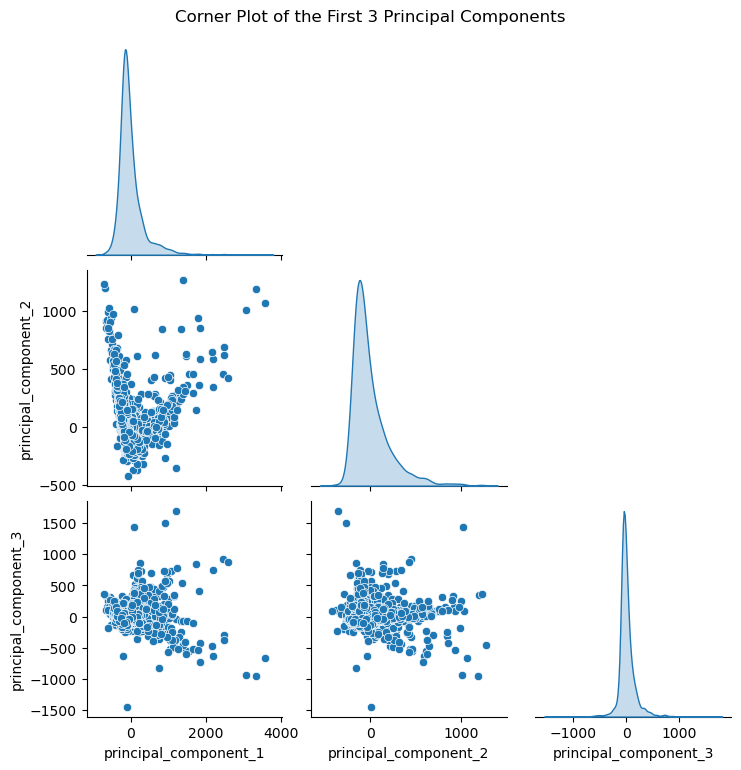

In [9]:
# Choose how many principal components you want to include in the corner plot
n = 3  # e.g., 5 PCs

# Build a list of the columns you want to plot
pc_columns = [f"principal_component_{i}" for i in range(1, n+1)]

# Use seaborn's pairplot to create a corner plot
sns.pairplot(
    df_pca[pc_columns], 
    diag_kind='kde',   # or 'hist' if you prefer histograms on the diagonal
    corner=True        # only plots the lower triangle for a cleaner look
)

plt.suptitle(f"Corner Plot of the First {n} Principal Components", y=1.02)
plt.show()
